# Summary statistics figure

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import pylab as plt

plt.style.use('matplotlib_style.txt')

In [2]:
# Load the data

iclr = pd.read_parquet('../data/iclr24v2.parquet')

genders = pd.read_parquet('../results/variables/iclr24v2/names_and_genders.parquet')

In [3]:
# Gender availability

first = genders.first_author_gender.isin(['male', 'female']).sum() / len(genders)
last  = genders.last_author_gender.isin(['male', 'female']).sum() / len(genders)

print(f'First author genders: {first*100:.1f}%')
print(f'Last author genders: {last*100:.1f}%')

First author genders: 41.8%
Last author genders: 49.9%


In [4]:
# Compute gender ratios

years = np.arange(2017, 2025)

gender_ratio_first = np.zeros_like(years).astype(float)
gender_ratio_last = np.zeros_like(years).astype(float)

for i, year in enumerate(years):
    gender_ratio_first[i] = np.sum(
        genders[iclr.year == year]["first_author_gender"].values == "female"
    ) / np.sum(
        np.isin(
            genders[iclr.year == year]["first_author_gender"].values, ["female", "male"]
        )
    )

    gender_ratio_last[i] = np.sum(
        genders[iclr.year == year]["last_author_gender"].values == "female"
    ) / np.sum(
        np.isin(
            genders[iclr.year == year]["last_author_gender"].values, ["female", "male"]
        )
    )
    
print('% '.join([f'{r*100:.1f}' for r in gender_ratio_first]))
print('% '.join([f'{r*100:.1f}' for r in gender_ratio_last]))

10.9% 11.1% 12.6% 16.6% 17.2% 17.0% 18.2% 20.6
9.9% 8.8% 11.9% 12.4% 12.0% 14.6% 16.6% 17.9


In [5]:
# Number of classes (subtracting 1 for 'unlabeled')

print(f'Number of classes: {iclr.labels.unique().size - 1}')

print(f'Fraction of labeled papers: {np.mean(iclr.labels != "unlabeled") * 100 :.1f}%')

Number of classes: 45
Fraction of labeled papers: 53.4%


<IPython.core.display.Javascript object>


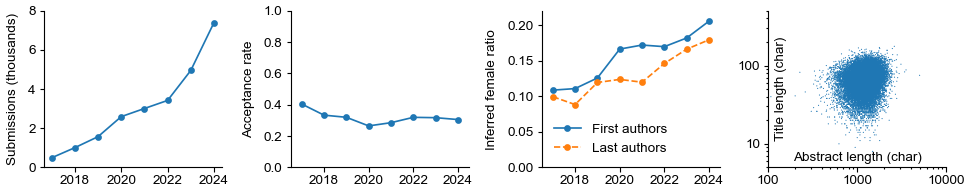

In [6]:
fig, axs = plt.subplots(ncols=4, figsize=(6.0, 1.2))

years = np.arange(2017, 2025)
n_submissions = [np.sum(iclr.year==y) for y in years]

axs[0].plot(years, np.array(n_submissions) / 1000, '.-')
axs[0].set_ylabel(f'Submissions (thousands)')
axs[0].set_ylim([0, 8])

accept_rate = [np.mean([d[:3]=='Acc' for d in iclr[iclr.year==y].decision]) for y in years]

axs[1].plot(years, accept_rate, '.-')
axs[1].set_ylabel('Acceptance rate')
axs[1].set_ylim([0, 1])
axs[1].set_xlim([2016.5, 2024.5])
    
axs[2].plot(years, gender_ratio_first, '.-', label='First authors')
axs[2].plot(years, gender_ratio_last, '.--', label='Last authors')
axs[2].set_ylabel('Inferred female ratio')
axs[2].set_ylim([0, .22])
axs[2].set_xlim([2016.5, 2024.5])
axs[2].legend()

len_abstract = [len(a) for a in iclr.abstract]
len_title =    [len(t) for t in iclr.title]

axs[3].scatter(len_abstract, len_title, s=1, ec='none', rasterized=True)
axs[3].set_xscale('log')
axs[3].set_yscale('log')
axs[3].set_xlim([100, 10000])
axs[3].set_ylim([5, 500])

import matplotlib.ticker as mticker
axs[3].xaxis.set_major_formatter(mticker.ScalarFormatter())
axs[3].yaxis.set_major_formatter(mticker.ScalarFormatter())

axs[3].text(1000, 6, 'Abstract length (char)', ha='center')
axs[3].text(120, 50, 'Title length (char)', va='center', rotation=90)

plt.savefig('../results/figures/summary-stats.png', dpi=300)
plt.savefig('../results/figures/summary-stats.pdf', dpi=300)

In [7]:
# Average acceptance rate

acc = np.mean([d[:3]=='Acc' for d in iclr.decision])
print(f'Average acceptance rate over all years: {acc * 100:.1f}%')

Average acceptance rate over all years: 30.7%


Number of reviewed papers: 24104
Mean number of reviews: 3.7
Fraction of papers with 3-4 reviews: 92.7%
Number of pairs of reviews: 244226
Correlation: 0.40


<IPython.core.display.Javascript object>


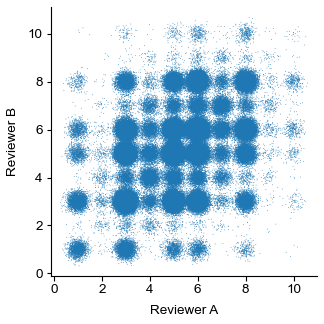

Correlation between the average of 4 reviews if all have rho=0.40: 0.73


In [8]:
# Score consistency

pairs = []

for score in iclr.scores:
    for i in range(len(score)):
        for j in range(len(score)):
            if i != j:
                pairs.append([score[i], score[j]])
                
pairs = np.array(pairs)
ns = np.array([len(s) for s in iclr.scores])

print(f'Number of reviewed papers: {ns[ns>0].size}')
print(f'Mean number of reviews: {np.mean(ns[ns>0]):.1f}')
fraction = np.sum((ns >= 3) & (ns <= 4)) / np.sum(ns > 0)
print(f'Fraction of papers with 3-4 reviews: {fraction * 100:.1f}%')
print(f'Number of pairs of reviews: {len(pairs)}')

rho = np.corrcoef(pairs.T)[0,1]

print(f'Correlation: {rho:.2f}')

plt.figure(figsize=(2, 2), layout='constrained')
plt.scatter(pairs[:,0] + np.random.randn(pairs.shape[0])/5,
            pairs[:,1] + np.random.randn(pairs.shape[0])/5, s=.5, ec='none')

plt.xlabel('Reviewer A')
plt.ylabel('Reviewer B')
plt.axis('equal')
# plt.title(f'All ICLR reviews ({pairs.shape[0]/1000:.0f}k pairs), r={rho:.2f}')

r = rho
k = 4
avcorr = (r * k**2) / (r * k * (k - 1) + k)
print(f'Correlation between the average of {k} reviews if all have rho={r:.2f}: {avcorr:.2f}')